# Data Preprocessing

In [1]:
#data preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier

# 文件路径列表
file_names = [
    "interventions_bxl.parquet.gzip",
    "interventions_bxl2.parquet.gzip",
    "interventions1.parquet.gzip",
    "interventions2.parquet.gzip",
    "interventions3.parquet.gzip"
]

# 读取文件
dfs = [pd.read_parquet(file_name) for file_name in file_names]

# 处理第二个 DataFrame 中的 'EventType and EventLevel' 列
df2 = dfs[1]
df2['event type trip'] = df2['EventType and EventLevel'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
df2['event level trip'] = df2['EventType and EventLevel'].apply(lambda x: x.split()[1] if isinstance(x, str) else None)

# 将 'T0' 和 'T3' 列转换为 datetime 格式并计算 'waiting time'
date_format = "%d%b%y:%H:%M:%S"
df2['T0'] = pd.to_datetime(df2['T0'], format=date_format, errors='coerce')
df2['T3'] = pd.to_datetime(df2['T3'], format=date_format, errors='coerce')
df2['waiting time'] = (df2['T3'] - df2['T0']).dt.total_seconds() // 60  # 保留到个位数

# 统一列名
column_mapping = [
    {'abandon_reason': 'abandon reason', 'waiting_time': 'waiting time', 'Eventlevel_trip': 'event level trip', 'vector_type': 'vector type', 'eventtype_trip': 'event type trip'},
    {'Abandon reason NL': 'abandon reason', 'Vector type NL': 'vector type'},
    {'Abandon reason': 'abandon reason', 'Waiting time': 'waiting time', 'EventType Trip': 'event type trip', 'EventLevel Trip': 'event level trip', 'Vector type': 'vector type'},
    {'Abandon reason': 'abandon reason', 'Waiting time': 'waiting time', 'EventType Trip': 'event type trip', 'EventLevel Trip': 'event level trip', 'Vector type': 'vector type'},
    {'Abandon reason': 'abandon reason', 'Waiting time': 'waiting time', 'EventType Trip': 'event type trip', 'EventLevel Trip': 'event level trip', 'Vector type': 'vector type'}
]

for i, df in enumerate(dfs):
    df.rename(columns=column_mapping[i], inplace=True)

# 处理 'abandon reason' 列：删除空值并编码
for i, df in enumerate(dfs):
    df.dropna(subset=['abandon reason'], inplace=True)
    if i == 1:
        df['abandon reason'] = df['abandon reason'].apply(lambda x: 1 if x == 'Dood Ter Plaatse' else 0)
    else:
        df['abandon reason'] = df['abandon reason'].apply(lambda x: 1 if x == 'Overleden' else 0)

# 提取每个 DataFrame 中 'event type trip' 列开头是 P039 和 P003 的行
filtered_dfs = []

for i, df in enumerate(dfs):
    filtered_df = df[df['event type trip'].str.startswith(('P039', 'P003'), na=False)]
    filtered_dfs.append(filtered_df)
    print(f"DataFrame {i+1} 提取的行数:", filtered_df.shape[0])

# 提取感兴趣的四列并合并
selected_columns = ['waiting time', 'event level trip', 'vector type', 'abandon reason']
merged_df = pd.concat([df[selected_columns] for df in filtered_dfs if all(col in df.columns for col in selected_columns)], ignore_index=True)

# 删除 'waiting time' 列中的空值
merged_df.dropna(subset=['waiting time'], inplace=True)

# 查看合并后的 DataFrame 的总行数
print("合并后的 DataFrame 总行数：", len(merged_df))

# 查看合并后的 DataFrame 的空值情况
print("合并后的 DataFrame 空值情况：")
print(merged_df.isnull().sum())

# 查看合并后的 DataFrame 的描述性统计信息，以检查异常值
print("\n合并后的 DataFrame 描述性统计信息：")
print(merged_df.describe())

# 打印合并后的 DataFrame 前几行数据
print("\n合并后的 DataFrame 数据样本：")
print(merged_df.head())

# 对分类变量进行独热编码
categorical_features = ['event level trip', 'vector type']
numeric_features = ['waiting time']

# 定义预处理步骤
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

# 对数据进行预处理
X = merged_df.drop(columns=['abandon reason'])
y = merged_df['abandon reason']
X_preprocessed = preprocessor.fit_transform(X)

# 打印预处理后数据的形状和类型
print("X_preprocessed shape:", X_preprocessed.shape)
print("X_preprocessed type:", type(X_preprocessed))
print("y shape:", y.shape)
print("y type:", type(y))

# 处理数据不平衡问题
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_preprocessed, y)

# 打印处理后数据的形状和类型
print("X_res shape:", X_res.shape)
print("X_res type:", type(X_res))
print("y_res shape:", y_res.shape)
print("y_res type:", type(y_res))

# 特征工程
# 特征选择（方差阈值法）
selector = VarianceThreshold(threshold=0.1)
X_res_var = selector.fit_transform(X_res)

# 检查选择后的特征数量
print("选择后特征数量（方差阈值法）：", X_res_var.shape[1])

# 基于树模型的重要性进行特征选择
clf = RandomForestClassifier(random_state=42)
clf.fit(X_res, y_res)
selector = SelectFromModel(clf, threshold="mean")
X_res_important = selector.fit_transform(X_res, y_res)

# 检查选择后的特征数量
print("选择后特征数量（基于树模型的重要性）：", X_res_important.shape[1])

# 特征交互
interaction_features = pd.DataFrame(X_res.toarray(), columns=preprocessor.get_feature_names_out())
interaction_features['waiting_time_event_level'] = interaction_features['num__waiting time'] * interaction_features['cat__event level trip_N01']
interaction_features['waiting_time_vector_type'] = interaction_features['num__waiting time'] * interaction_features['cat__vector type_AMB']

# 更新特征矩阵
X_res_interaction = np.hstack((X_res.toarray(), interaction_features[['waiting_time_event_level', 'waiting_time_vector_type']]))

# 特征变换
interaction_features['log_waiting_time'] = np.log1p(interaction_features['num__waiting time'])
X_res_transformed = np.hstack((X_res_interaction, interaction_features[['log_waiting_time']]))

# 数据增强（SMOTE）
smote = SMOTE(random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X_res_transformed, y_res)

# 数据增强（ADASYN）
adasyn = ADASYN(random_state=42)
X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X_res_transformed, y_res)

# 数据拆分
X_train, X_temp, y_train, y_temp = train_test_split(X_res_adasyn, y_res_adasyn, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 保存数据以供后续模型使用
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

print("数据已保存，准备进行模型训练。")

DataFrame 1 提取的行数: 801
DataFrame 2 提取的行数: 114
DataFrame 3 提取的行数: 1419
DataFrame 4 提取的行数: 1261
DataFrame 5 提取的行数: 1525
合并后的 DataFrame 总行数： 3694
合并后的 DataFrame 空值情况：
waiting time        0
event level trip    0
vector type         0
abandon reason      0
dtype: int64

合并后的 DataFrame 描述性统计信息：
       waiting time  abandon reason
count   3694.000000     3694.000000
mean      13.397401        0.725772
std       12.421719        0.446185
min        1.000000        0.000000
25%        9.000000        0.000000
50%       11.000000        1.000000
75%       15.000000        1.000000
max      447.000000        1.000000

合并后的 DataFrame 数据样本：
   waiting time event level trip vector type  abandon reason
0          11.0              N05         AMB               0
2           8.0              N01         AMB               1
3           8.0              N05         AMB               0
4          16.0              N05         AMB               0
6          18.0              N05         AMB               

# Random Forest

## Model Training, Preditcing and Evaluating

[I 2024-05-28 10:34:05,805] A new study created in memory with name: no-name-0ac0e0d2-4890-4bee-a1a9-8769a4ffeb5e
[I 2024-05-28 10:34:08,410] Trial 0 finished with value: 0.7966984465157567 and parameters: {'n_estimators': 215, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7966984465157567.
[I 2024-05-28 10:34:18,114] Trial 1 finished with value: 0.7942995117620949 and parameters: {'n_estimators': 805, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7966984465157567.
[I 2024-05-28 10:34:22,874] Trial 2 finished with value: 0.795899511762095 and parameters: {'n_estimators': 463, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.7966984465157567.
[I 2024-05-28 10:34:32,079] Trial 3 finished with value: 0.795899511762095 and parameters: {'n_estimators': 876, 'max_depth': 4, 'min_

Random Forest Best parameters found:  {'n_estimators': 989, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
准确率 (Accuracy)： 0.777363184079602
精确率 (Precision)： 0.8174157303370787
召回率 (Recall)： 0.7185185185185186
F1-Score： 0.7647831800262812
ROC-AUC Score： 0.8415142795259755
分类报告：
               precision    recall  f1-score   support

           0       0.75      0.84      0.79       399
           1       0.82      0.72      0.76       405

    accuracy                           0.78       804
   macro avg       0.78      0.78      0.78       804
weighted avg       0.78      0.78      0.78       804

混淆矩阵：
 [[334  65]
 [114 291]]


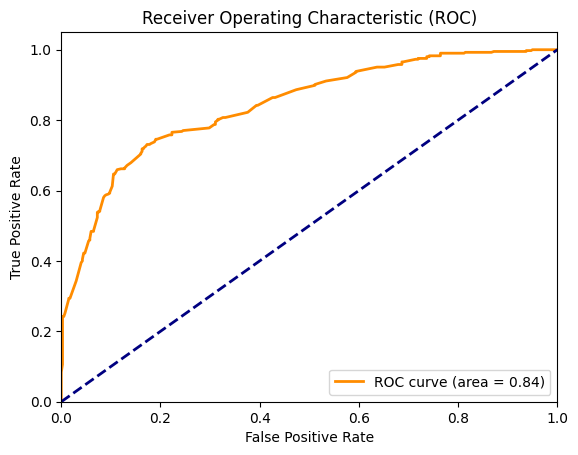

准确率 (Accuracy)： 0.7850931677018633
精确率 (Precision)： 0.7967479674796748
召回率 (Recall)： 0.75
F1-Score： 0.7726675427069645
ROC-AUC Score： 0.8260704402826505
分类报告：
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       413
           1       0.80      0.75      0.77       392

    accuracy                           0.79       805
   macro avg       0.79      0.78      0.78       805
weighted avg       0.79      0.79      0.78       805

混淆矩阵：
 [[338  75]
 [ 98 294]]


In [2]:
#randomforest
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 加载数据
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# 定义随机森林的目标函数
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    
    model = RandomForestClassifier(**param, random_state=42)
    
    # 使用K折交叉验证进行模型评估
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()

# 开始优化随机森林
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

# 输出最佳参数
print("Random Forest Best parameters found: ", study_rf.best_params)

# 使用最佳参数训练随机森林模型
best_params_rf = study_rf.best_params
model_rf = RandomForestClassifier(**best_params_rf, random_state=42)
model_rf.fit(X_train, y_train)

# 进行验证集预测
y_val_pred_rf = model_rf.predict(X_val)
y_val_proba_rf = model_rf.predict_proba(X_val)[:, 1]

# 计算和输出更多评价指标
def evaluate_model(y_true, y_pred, y_proba=None):
    print("准确率 (Accuracy)：", accuracy_score(y_true, y_pred))
    print("精确率 (Precision)：", precision_score(y_true, y_pred))
    print("召回率 (Recall)：", recall_score(y_true, y_pred))
    print("F1-Score：", f1_score(y_true, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        print("ROC-AUC Score：", roc_auc)
    
    print("分类报告：\n", classification_report(y_true, y_pred))
    print("混淆矩阵：\n", confusion_matrix(y_true, y_pred))

# 输出更多评价指标
evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf)

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_val, y_val_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 进行测试集预测
y_test_pred_rf = model_rf.predict(X_test)
y_test_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# 输出测试集更多评价指标
evaluate_model(y_test, y_test_pred_rf, y_test_proba_rf)

## Visualizing Important Features

Feature ranking:
1. feature 'cat__event level trip_N1' (0.24435393831384408)
2. feature 'cat__event level trip_N0' (0.17990649944441472)
3. feature 'cat__event level trip_N5' (0.12720634059353947)
4. feature 'cat__event level trip_N4' (0.11233189864453712)
5. feature 'log_waiting_time' (0.08682144232856694)
6. feature 'num__waiting time' (0.08582976057616067)
7. feature 'cat__event level trip_N3' (0.05796591698331555)
8. feature 'cat__event level trip_N2' (0.024380364520356544)
9. feature 'cat__vector type_Ambulance' (0.023172569845203893)
10. feature 'cat__vector type_AMB' (0.01178917151293927)
11. feature 'cat__vector type_PIT' (0.011299935462907416)
12. feature 'waiting_time_vector_type' (0.009895175322919367)
13. feature 'cat__event level trip_N05' (0.00815094629856991)
14. feature 'waiting_time_event_level' (0.005353440477016112)
15. feature 'cat__event level trip_N01' (0.0039755592702357965)
16. feature 'cat__event level trip_N03' (0.003203556438614309)
17. feature 'cat__vector t

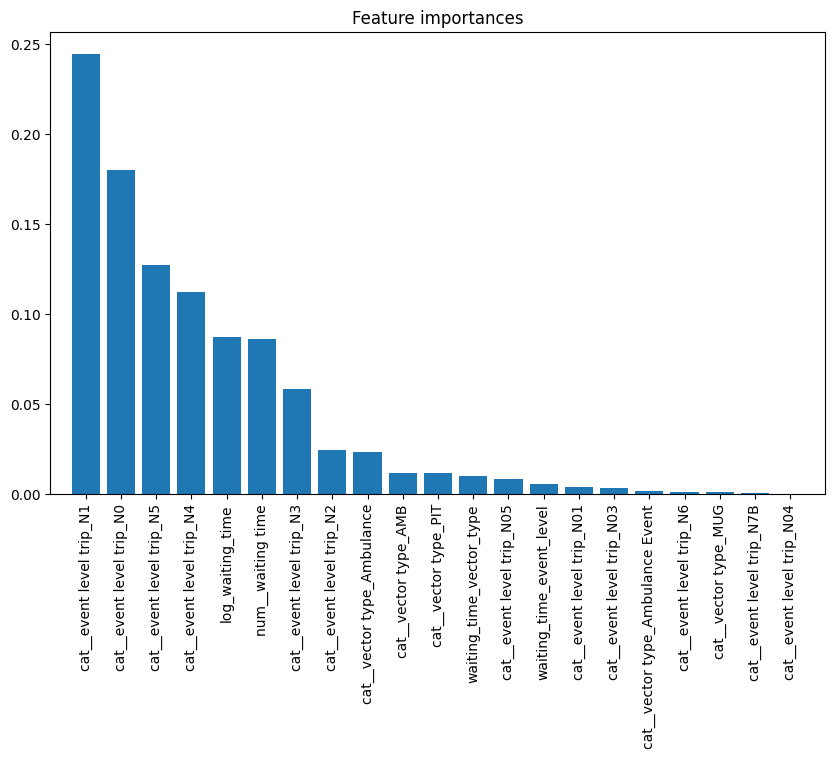

In [3]:
# 提取原始特征名称
original_feature_names = preprocessor.get_feature_names_out()

# 添加新特征名称（交互特征和特征变换）
interaction_feature_names = [
    'waiting_time_event_level', 
    'waiting_time_vector_type', 
    'log_waiting_time'
]

# 合并所有特征名称
all_feature_names = list(original_feature_names) + interaction_feature_names

# 确保特征名称的长度与特征矩阵的列数匹配
assert len(all_feature_names) == X_train.shape[1], "Feature names length does not match the number of features."

# 获取特征重要性
feature_importances = model_rf.feature_importances_

# 排序特征重要性
indices = np.argsort(feature_importances)[::-1]

# 打印特征重要性
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. feature '{all_feature_names[index]}' ({feature_importances[index]})")

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [all_feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
# XGBoost

## Model Training, Preditcing and Evaluating

[I 2024-05-28 10:41:18,605] A new study created in memory with name: no-name-0e80328e-a899-4ce5-b963-544c5e808f20
C:\Users\qinpe\AppData\Local\Temp\ipykernel_3732\3430568858.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2024-05-28 10:41:19,469] Trial 0 finished with value: 0.7996285841100754 and parameters: {'n_estimators': 315, 'max_depth': 3, 'learning_rate': 0.05867212740945465, 'subsample': 0.7415552730672159, 'colsample_bytree': 0.7830152064132965, 'gamma': 0.22860044019992187}. Best is trial 0 with value: 0.7996285841100754.
C:\Users\qinpe\AppData\Local\Temp\ipykernel_3732\3430568858.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

XGBoost Best parameters found:  {'n_estimators': 610, 'max_depth': 6, 'learning_rate': 0.2314054467204012, 'subsample': 0.7775850646396346, 'colsample_bytree': 0.84501239622975, 'gamma': 0.2503623320749908}
准确率 (Accuracy)： 0.7761194029850746
精确率 (Precision)： 0.8151260504201681
召回率 (Recall)： 0.7185185185185186
F1-Score： 0.7637795275590551
ROC-AUC Score： 0.83905752034407
分类报告：
               precision    recall  f1-score   support

           0       0.74      0.83      0.79       399
           1       0.82      0.72      0.76       405

    accuracy                           0.78       804
   macro avg       0.78      0.78      0.78       804
weighted avg       0.78      0.78      0.78       804

混淆矩阵：
 [[333  66]
 [114 291]]


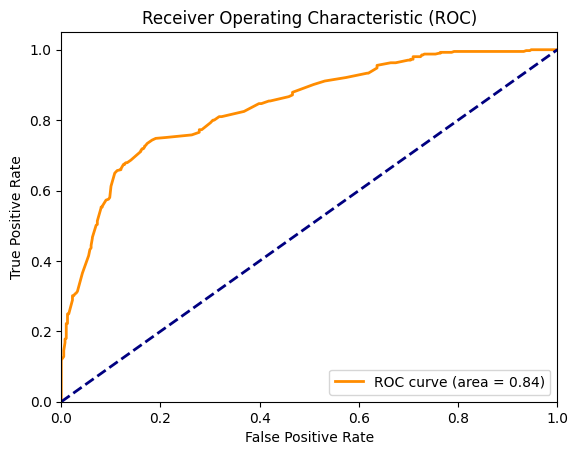

准确率 (Accuracy)： 0.7813664596273292
精确率 (Precision)： 0.7903225806451613
召回率 (Recall)： 0.75
F1-Score： 0.7696335078534031
ROC-AUC Score： 0.8227874684982952
分类报告：
               precision    recall  f1-score   support

           0       0.77      0.81      0.79       413
           1       0.79      0.75      0.77       392

    accuracy                           0.78       805
   macro avg       0.78      0.78      0.78       805
weighted avg       0.78      0.78      0.78       805

混淆矩阵：
 [[335  78]
 [ 98 294]]


In [4]:
#xgboost
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 加载数据
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# 定义XGBoost的目标函数
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5)
    }
    
    model = XGBClassifier(**param, random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    # 使用K折交叉验证进行模型评估
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()

# 开始优化XGBoost
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)

# 输出最佳参数
print("XGBoost Best parameters found: ", study_xgb.best_params)

# 使用最佳参数训练XGBoost模型
best_params_xgb = study_xgb.best_params
model_xgb = XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)

# 进行验证集预测
y_val_pred_xgb = model_xgb.predict(X_val)
y_val_proba_xgb = model_xgb.predict_proba(X_val)[:, 1]

# 计算和输出更多评价指标
def evaluate_model(y_true, y_pred, y_proba=None):
    print("准确率 (Accuracy)：", accuracy_score(y_true, y_pred))
    print("精确率 (Precision)：", precision_score(y_true, y_pred))
    print("召回率 (Recall)：", recall_score(y_true, y_pred))
    print("F1-Score：", f1_score(y_true, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        print("ROC-AUC Score：", roc_auc)
    
    print("分类报告：\n", classification_report(y_true, y_pred))
    print("混淆矩阵：\n", confusion_matrix(y_true, y_pred))

# 输出更多评价指标
evaluate_model(y_val, y_val_pred_xgb, y_val_proba_xgb)

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_val, y_val_proba_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 进行测试集预测
y_test_pred_xgb = model_xgb.predict(X_test)
y_test_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# 输出测试集更多评价指标
evaluate_model(y_test, y_test_pred_xgb, y_test_proba_xgb)

## Visualizing Important Features

Feature ranking:
1. feature 'cat__event level trip_N0' (0.1630372256040573)
2. feature 'cat__event level trip_N4' (0.1118035838007927)
3. feature 'cat__event level trip_N1' (0.11070351302623749)
4. feature 'cat__event level trip_N03' (0.08117900788784027)
5. feature 'cat__vector type_AMB' (0.07719336450099945)
6. feature 'cat__event level trip_N3' (0.06632847338914871)
7. feature 'cat__event level trip_N05' (0.06402436643838882)
8. feature 'cat__event level trip_N5' (0.05434439703822136)
9. feature 'cat__event level trip_N01' (0.04883679375052452)
10. feature 'cat__vector type_Ambulance' (0.04053889587521553)
11. feature 'cat__event level trip_N2' (0.02659996971487999)
12. feature 'log_waiting_time' (0.024980487301945686)
13. feature 'num__waiting time' (0.024527115747332573)
14. feature 'cat__vector type_MUG' (0.023676682263612747)
15. feature 'waiting_time_vector_type' (0.022192973643541336)
16. feature 'cat__vector type_PIT' (0.022177506238222122)
17. feature 'waiting_time_event_lev

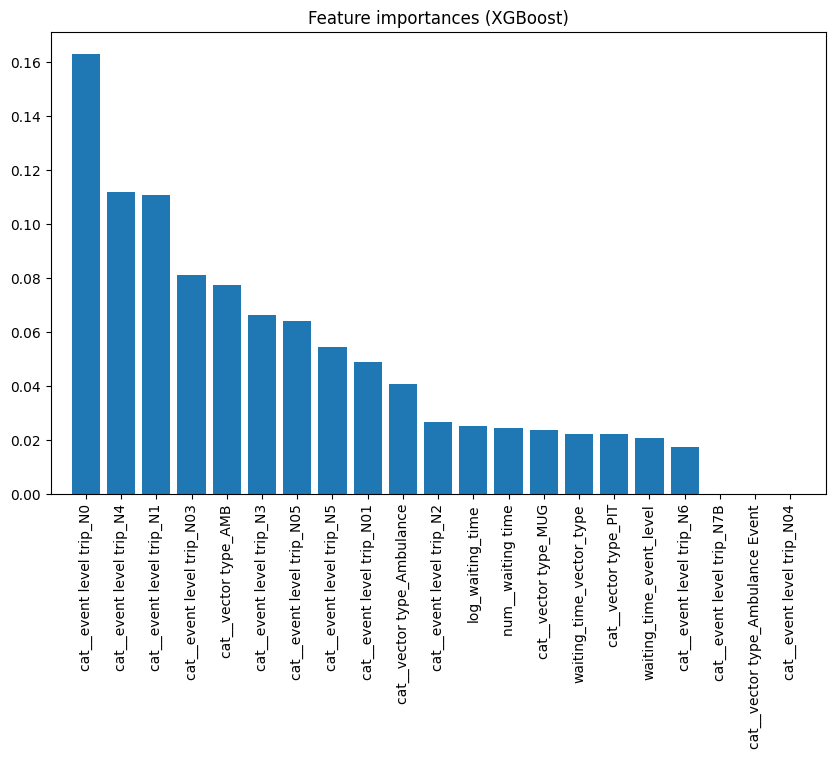

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 提取原始特征名称
original_feature_names = preprocessor.get_feature_names_out()

# 添加新特征名称（交互特征和特征变换）
interaction_feature_names = [
    'waiting_time_event_level', 
    'waiting_time_vector_type', 
    'log_waiting_time'
]

# 合并所有特征名称
all_feature_names = list(original_feature_names) + interaction_feature_names

# 确保特征名称的长度与特征矩阵的列数匹配
assert len(all_feature_names) == X_train.shape[1], "Feature names length does not match the number of features."

# 获取特征重要性
feature_importances = model_xgb.feature_importances_

# 排序特征重要性
indices = np.argsort(feature_importances)[::-1]

# 打印特征重要性
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. feature '{all_feature_names[index]}' ({feature_importances[index]})")

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.title("Feature importances (XGBoost)")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [all_feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# CatBoost

## Model Training, Preditcing and Evaluating

[I 2024-05-28 10:43:48,279] A new study created in memory with name: no-name-1ec70639-7ad2-4cd0-b3a3-fc0a81bd5851
C:\Users\qinpe\AppData\Local\Temp\ipykernel_3732\82983477.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2024-05-28 10:43:58,823] Trial 0 finished with value: 0.8014924101198402 and parameters: {'iterations': 858, 'depth': 4, 'learning_rate': 0.22903910634175903, 'l2_leaf_reg': 54.345815912117146, 'border_count': 20, 'bagging_temperature': 0.18250632329241767}. Best is trial 0 with value: 0.8014924101198402.
C:\Users\qinpe\AppData\Local\Temp\ipykernel_3732\82983477.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

CatBoost Best parameters found:  {'iterations': 395, 'depth': 6, 'learning_rate': 0.08325340016490153, 'l2_leaf_reg': 6.760654581654531, 'border_count': 240, 'bagging_temperature': 0.2261561663621834}
准确率 (Accuracy)： 0.7761194029850746
精确率 (Precision)： 0.8116343490304709
召回率 (Recall)： 0.7234567901234568
F1-Score： 0.7650130548302873
ROC-AUC Score： 0.8460441226523099
分类报告：
               precision    recall  f1-score   support

           0       0.75      0.83      0.79       399
           1       0.81      0.72      0.77       405

    accuracy                           0.78       804
   macro avg       0.78      0.78      0.78       804
weighted avg       0.78      0.78      0.78       804

混淆矩阵：
 [[331  68]
 [112 293]]


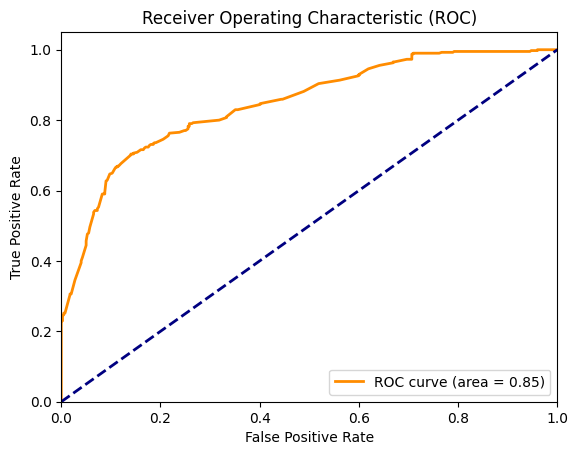

准确率 (Accuracy)： 0.7838509316770186
精确率 (Precision)： 0.7898936170212766
召回率 (Recall)： 0.7576530612244898
F1-Score： 0.7734375
ROC-AUC Score： 0.8266726787567326
分类报告：
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       413
           1       0.79      0.76      0.77       392

    accuracy                           0.78       805
   macro avg       0.78      0.78      0.78       805
weighted avg       0.78      0.78      0.78       805

混淆矩阵：
 [[334  79]
 [ 95 297]]


In [6]:
#catboost
from catboost import CatBoostClassifier

# 加载数据
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# 定义CatBoost的目标函数
def objective_cat(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e2),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1)
    }
    
    model = CatBoostClassifier(**param, random_state=42, verbose=0)
    
    # 使用K折交叉验证进行模型评估
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()

# 开始优化CatBoost
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=50)

# 输出最佳参数
print("CatBoost Best parameters found: ", study_cat.best_params)

# 使用最佳参数训练CatBoost模型
best_params_cat = study_cat.best_params
model_cat = CatBoostClassifier(**best_params_cat, random_state=42, verbose=0)
model_cat.fit(X_train, y_train)

# 进行验证集预测
y_val_pred_cat = model_cat.predict(X_val)
y_val_proba_cat = model_cat.predict_proba(X_val)[:, 1]

# 计算和输出更多评价指标
def evaluate_model(y_true, y_pred, y_proba=None):
    print("准确率 (Accuracy)：", accuracy_score(y_true, y_pred))
    print("精确率 (Precision)：", precision_score(y_true, y_pred))
    print("召回率 (Recall)：", recall_score(y_true, y_pred))
    print("F1-Score：", f1_score(y_true, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        print("ROC-AUC Score：", roc_auc)
    
    print("分类报告：\n", classification_report(y_true, y_pred))
    print("混淆矩阵：\n", confusion_matrix(y_true, y_pred))

# 输出更多评价指标
evaluate_model(y_val, y_val_pred_cat, y_val_proba_cat)

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_val, y_val_proba_cat)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 进行测试集预测
y_test_pred_cat = model_cat.predict(X_test)
y_test_proba_cat = model_cat.predict_proba(X_test)[:, 1]

# 输出测试集更多评价指标
evaluate_model(y_test, y_test_pred_cat, y_test_proba_cat)

## Visualizing Important Features

CatBoost Feature ranking:
1. feature 'cat__event level trip_N0' (28.738233006528166)
2. feature 'cat__event level trip_N1' (28.222192315645437)
3. feature 'cat__event level trip_N4' (11.029779082883383)
4. feature 'num__waiting time' (7.727846215784033)
5. feature 'log_waiting_time' (6.488397188832922)
6. feature 'cat__event level trip_N5' (4.797888152521776)
7. feature 'cat__event level trip_N2' (3.928107100023797)
8. feature 'cat__event level trip_N3' (2.9620462691107896)
9. feature 'cat__vector type_Ambulance' (1.8341640845215426)
10. feature 'cat__vector type_PIT' (1.4696567731586652)
11. feature 'waiting_time_vector_type' (0.7307724671693051)
12. feature 'cat__event level trip_N01' (0.6589057519382321)
13. feature 'waiting_time_event_level' (0.5504143291457058)
14. feature 'cat__event level trip_N05' (0.3025962466855667)
15. feature 'cat__vector type_AMB' (0.20702404423982973)
16. feature 'cat__event level trip_N03' (0.11726152905474423)
17. feature 'cat__event level trip_N6' (0.0

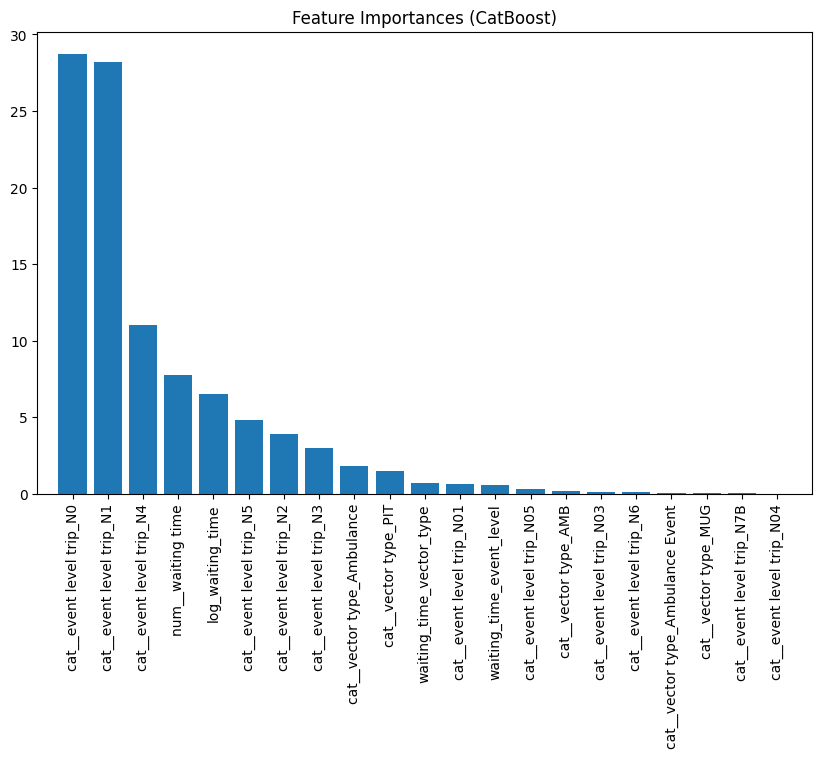

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 提取原始特征名称
original_feature_names = preprocessor.get_feature_names_out()

# 添加新特征名称（交互特征和特征变换）
interaction_feature_names = [
    'waiting_time_event_level', 
    'waiting_time_vector_type', 
    'log_waiting_time'
]

# 合并所有特征名称
all_feature_names = list(original_feature_names) + interaction_feature_names

# 确保特征名称的长度与特征矩阵的列数匹配
assert len(all_feature_names) == X_train.shape[1], "Feature names length does not match the number of features."

# 获取CatBoost模型的特征重要性
cat_feature_importances = model_cat.get_feature_importance()

# 排序特征重要性
cat_indices = np.argsort(cat_feature_importances)[::-1]

# 打印CatBoost模型的特征重要性
print("CatBoost Feature ranking:")
for i, index in enumerate(cat_indices):
    print(f"{i + 1}. feature '{all_feature_names[index]}' ({cat_feature_importances[index]})")

# 可视化CatBoost模型的特征重要性
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (CatBoost)")
plt.bar(range(X_train.shape[1]), cat_feature_importances[cat_indices], align="center")
plt.xticks(range(X_train.shape[1]), [all_feature_names[i] for i in cat_indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


# Model Comparision

## Comparing Confusion Matrix

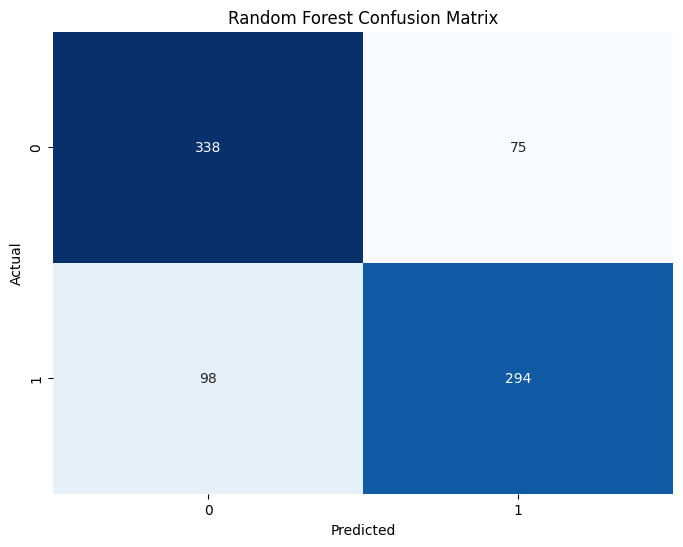

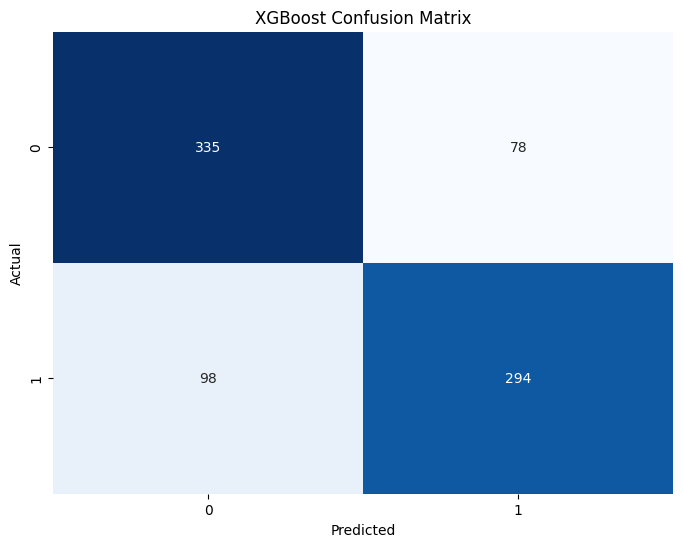

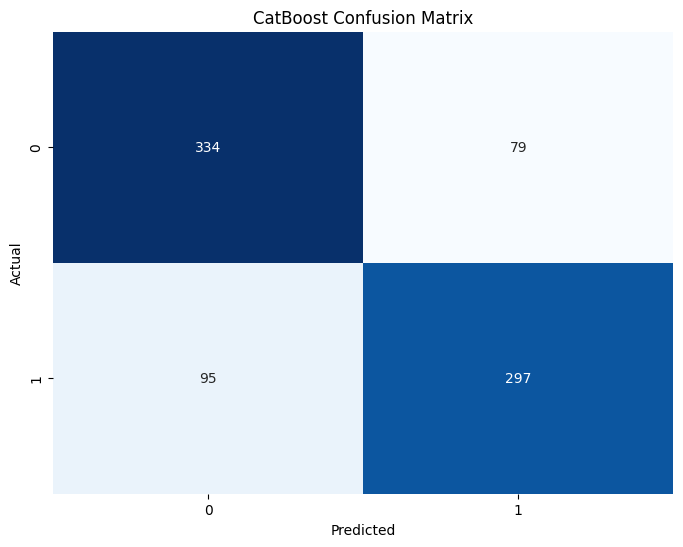

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, title):
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    
    # 可视化混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# 使用之前计算的预测结果
y_test_pred_rf = model_rf.predict(X_test)
y_test_pred_xgb = model_xgb.predict(X_test)
y_test_pred_cat = model_cat.predict(X_test)

# 绘制随机森林模型的混淆矩阵
plot_confusion_matrix(y_test, y_test_pred_rf, 'Random Forest Confusion Matrix')

# 绘制XGBoost模型的混淆矩阵
plot_confusion_matrix(y_test, y_test_pred_xgb, 'XGBoost Confusion Matrix')

# 绘制CatBoost模型的混淆矩阵
plot_confusion_matrix(y_test, y_test_pred_cat, 'CatBoost Confusion Matrix')

## Comparing ROC-AUC Curve

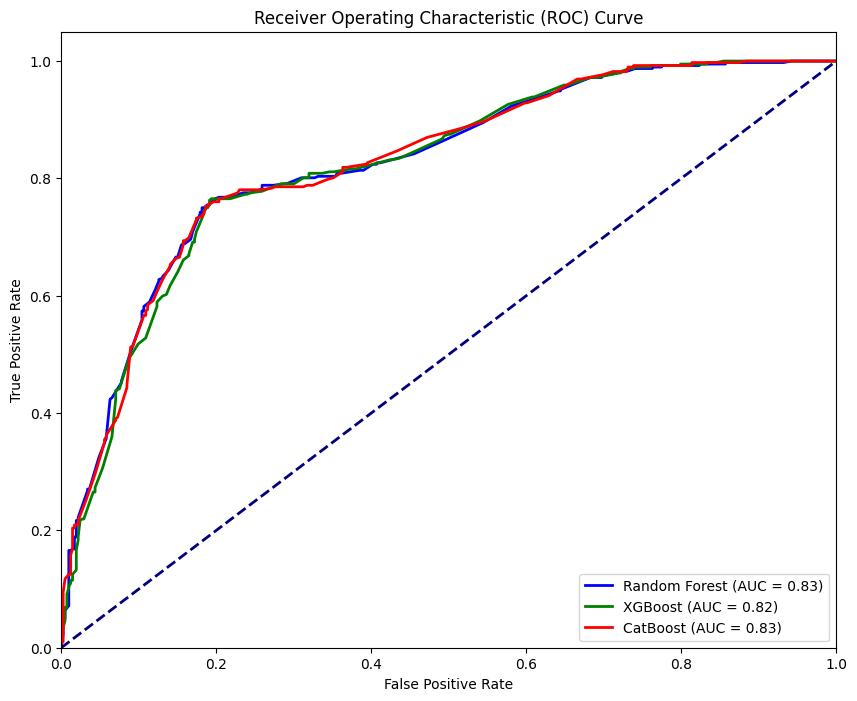

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test, y_test_proba_rf, y_test_proba_xgb, y_test_proba_cat are defined
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_cat, tpr_cat, _ = roc_curve(y_test, y_test_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_cat, tpr_cat, color='red', lw=2, label=f'CatBoost (AUC = {roc_auc_cat:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Compare Accuracy, Precision, Recall, F1 Score, and ROC-AUC Score

{'accuracy': 0.7850931677018633, 'precision': 0.7967479674796748, 'recall': 0.75, 'f1': 0.7726675427069645, 'roc_auc': 0.8260704402826505}
{'accuracy': 0.7813664596273292, 'precision': 0.7903225806451613, 'recall': 0.75, 'f1': 0.7696335078534031, 'roc_auc': 0.8227874684982952}
{'accuracy': 0.7838509316770186, 'precision': 0.7898936170212766, 'recall': 0.7576530612244898, 'f1': 0.7734375, 'roc_auc': 0.8266726787567326}


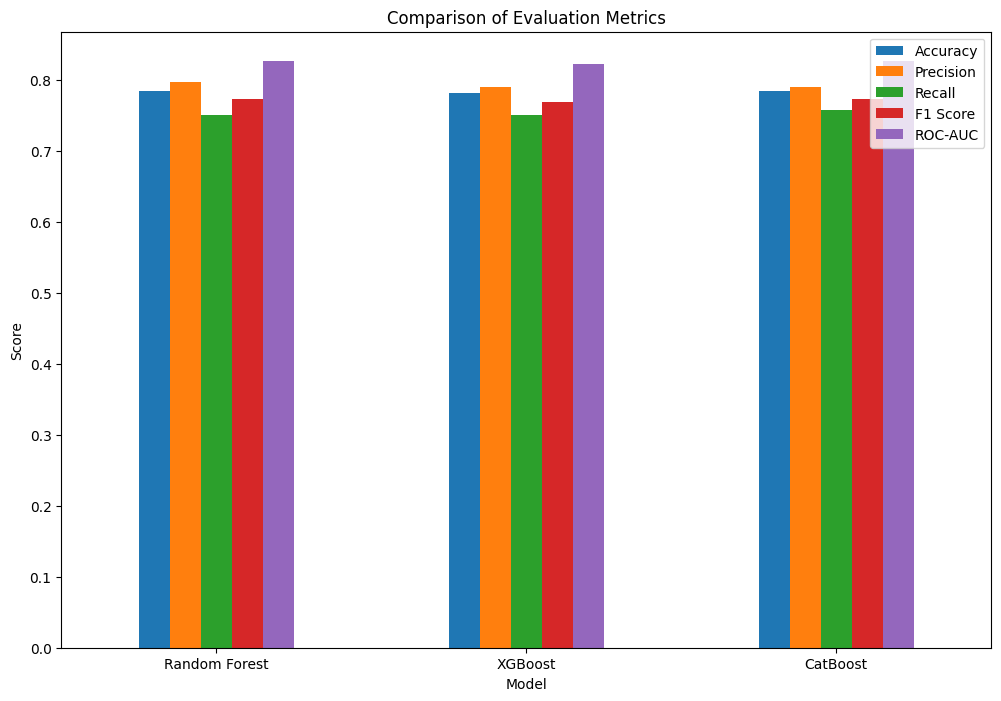

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(y_true, y_pred, y_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': None  # 默认值为 None
    }
    
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    
    return metrics

# 假设 y_test, y_test_pred_rf, y_test_proba_rf, y_test_pred_xgb, y_test_proba_xgb, y_test_pred_cat, y_test_proba_cat 都已定义
metrics_rf = evaluate_model(y_test, y_test_pred_rf, y_test_proba_rf)
metrics_xgb = evaluate_model(y_test, y_test_pred_xgb, y_test_proba_xgb)
metrics_cat = evaluate_model(y_test, y_test_pred_cat, y_test_proba_cat)

# 打印以检查返回值是否正确
print(metrics_rf)
print(metrics_xgb)
print(metrics_cat)

# 确保所有指标都存在
metrics_dict = {
    'Accuracy': [metrics_rf['accuracy'], metrics_xgb['accuracy'], metrics_cat['accuracy']],
    'Precision': [metrics_rf['precision'], metrics_xgb['precision'], metrics_cat['precision']],
    'Recall': [metrics_rf['recall'], metrics_xgb['recall'], metrics_cat['recall']],
    'F1 Score': [metrics_rf['f1'], metrics_xgb['f1'], metrics_cat['f1']],
    'ROC-AUC': [metrics_rf['roc_auc'], metrics_xgb['roc_auc'], metrics_cat['roc_auc']]
}

# 创建 DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Random Forest', 'XGBoost', 'CatBoost'])

# 绘制比较图表
metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Evaluation Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()
